In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical


Using TensorFlow backend.


In [3]:
print(tf.keras.__version__)

2.2.4-tf


In [4]:
# Initialising the compression dimensions
img_width = 256
img_height =256
border = 5


In [42]:
# Extracting the file names of the images and masks in training, test and validation folders
isic_train = next(os.walk("D:/ISIC2018_Task1-2_Training_Input_x2"))[2] # returns all the files "DIR."
isic_seg_train=next(os.walk("D:/ISIC2018_Task1_Training_GroundTruth_x2"))[2] # returns all the files "DIR."

print("No. of images in training folder= ",len(isic_train))
print("No. of images in test folder= ",len(isic_seg_train))


No. of images in training folder=  2594
No. of images in test folder=  2594


In [43]:
isic_train_sort=sorted(isic_train) # Sorting of data wit respect to labels
isic_seg_train_sort=sorted(isic_seg_train) # Sorting of data wit respect to labels


In [44]:
def Load_img(inp_path,isic):
    X= np.zeros((len(isic),img_height,img_width,1),dtype=np.float32)
    for n, id_ in tqdm_notebook(enumerate(isic), total=len(isic)): # capture all the images ids using tqdm
       
        img = load_img(inp_path+id_, color_mode = 'grayscale')  # Load images here
        x_img = img_to_array(img) # Convert images to array
        x_img = resize(x_img,(256,256,1),mode = 'constant',preserve_range = True)
        X[n] = x_img/255 # Normalize the images
    return X
    

In [45]:
def Load_segmentation(inp_path,isic):
    X= np.zeros((len(isic),img_height,img_width,1),dtype=np.uint8)
    for n, id_ in tqdm_notebook(enumerate(isic), total=len(isic)):
        # Load images
        img = load_img(inp_path+id_,color_mode = 'grayscale')
        x_img = img_to_array(img)
        x_img = resize(x_img,(256,256,1),mode = 'constant', preserve_range = True)
        X[n] = x_img
    return X

In [47]:
# Loading the images for the training data set
X_ISIC_train = Load_img("D:/ISIC2018_Task1-2_Training_Input_x2/",isic_train_sort)

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
Y_ISIC_train=Load_segmentation("D:/ISIC2018_Task1_Training_GroundTruth_x2/",isic_seg_train_sort)


C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_ISIC_train, Y_ISIC_train, test_size=0.20, random_state=42)

In [50]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [51]:
# loading the imgaes for validation and testing dataset

Y_ISIC_train_sc = y_train//255
Y_ISIC_test_sc = y_test//255
Y_ISIC_val_sc = y_val//255


In [52]:
Y_ISIC_train_cat = to_categorical(Y_ISIC_train_sc) # one hot encoding
Y_ISIC_test_cat = to_categorical(Y_ISIC_test_sc) # one hot encoding
Y_ISIC_val_cat = to_categorical(Y_ISIC_val_sc) # one hot encoding

In [75]:
# Dice Coeffient
from keras import backend as K
def dice_coeff(y_true, y_pred, smooth=1):
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersect
    coeff_dice = K.mean((intersect + smooth) / (union + smooth), axis=0)
    return coeff_dice

In [76]:
def dice_loss(y_true, y_pred, smooth = 1):
    return 1 - dice_coeff(y_true, y_pred, smooth = 1)

In [77]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    layer = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    # It draws samples from a truncated normal distribution centered on 0 
    if batchnorm:
        layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    # second layer
    layer = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    return layer


In [78]:
def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    # contracting path - reduce enoder part
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path - Decoder part
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [79]:
input_img = Input((img_height, img_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy",dice_coeff])



In [58]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 256, 256, 16) 64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 256, 256, 16) 0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [59]:
# train the model. callbacks to save the model while training, 
# lower the learning rate if the validation loss plateaus and perform early stopping.

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ISIC.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [80]:
results = model.fit(X_train, Y_ISIC_train_cat, batch_size=32, epochs=50, callbacks=callbacks,
                    validation_data=(X_val, Y_ISIC_val_cat))


Train on 1556 samples, validate on 519 samples
Epoch 1/50
1556/1556 [==============================] - 15s 10ms/step - loss: 0.4174 - accuracy: 0.8455 - dice_coeff: 0.5835 - val_loss: 0.5773 - val_accuracy: 0.8589 - val_dice_coeff: 0.4221

Epoch 00001: val_loss did not improve from 0.09817
Epoch 2/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.2868 - accuracy: 0.9051 - dice_coeff: 0.7132 - val_loss: 0.4836 - val_accuracy: 0.7623 - val_dice_coeff: 0.5131

Epoch 00002: val_loss did not improve from 0.09817
Epoch 3/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.2262 - accuracy: 0.9172 - dice_coeff: 0.7741 - val_loss: 0.3261 - val_accuracy: 0.8779 - val_dice_coeff: 0.6727

Epoch 00003: val_loss did not improve from 0.09817
Epoch 4/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.1914 - accuracy: 0.9200 - dice_coeff: 0.8087 - val_loss: 0.2502 - val_accuracy: 0.8767 - val_dice_coeff: 0.7503

Epoch 00004: val_loss did not i

1556/1556 [==============================] - 13s 8ms/step - loss: 0.0842 - accuracy: 0.9528 - dice_coeff: 0.9158 - val_loss: 0.0999 - val_accuracy: 0.9406 - val_dice_coeff: 0.8996

Epoch 00034: val_loss did not improve from 0.09817
Epoch 35/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.0827 - accuracy: 0.9538 - dice_coeff: 0.9174 - val_loss: 0.1046 - val_accuracy: 0.9371 - val_dice_coeff: 0.8952

Epoch 00035: val_loss did not improve from 0.09817
Epoch 36/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.0843 - accuracy: 0.9529 - dice_coeff: 0.9156 - val_loss: 0.0975 - val_accuracy: 0.9424 - val_dice_coeff: 0.9020

Epoch 00036: val_loss improved from 0.09817 to 0.09753, saving model to model-ISIC.h5
Epoch 37/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.0823 - accuracy: 0.9539 - dice_coeff: 0.9176 - val_loss: 0.1014 - val_accuracy: 0.9395 - val_dice_coeff: 0.8983

Epoch 00037: val_loss did not improve from 0.09753
E

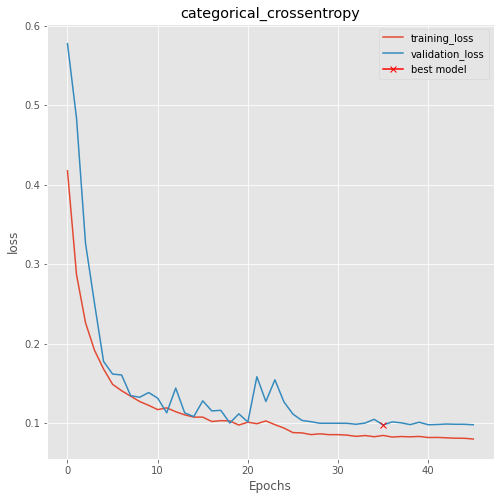

In [81]:
plt.figure(figsize=(8, 8))
plt.title("categorical_crossentropy")
plt.plot(results.history["loss"], label="training_loss")
plt.plot(results.history["val_loss"], label="validation_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();


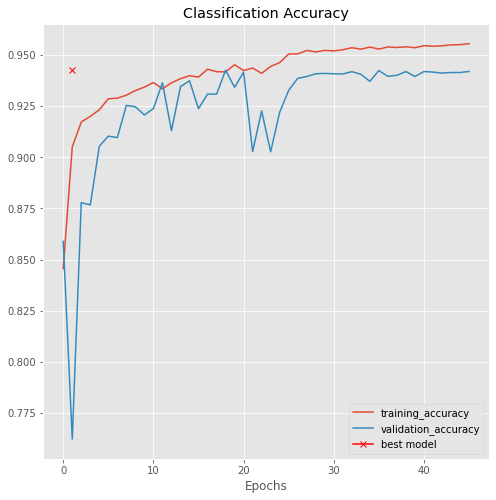

In [82]:
# Plotting the training and validation accuracy with respect to epochs
plt.figure(figsize=(8,8))
plt.title("Classification Accuracy")
plt.plot(results.history["accuracy"],label="training_accuracy")
plt.plot(results.history["val_accuracy"],label="validation_accuracy")
plt.plot(np.argmin(results.history["val_accuracy"]),np.max(results.history["val_accuracy"]),marker="x",color="r",label="best model")
plt.xlabel("Epochs")
plt.legend();

In [83]:
# load the best model
model.load_weights('model-ISIC.h5')
test_preds=model.predict(X_test,verbose=1) # predict the model
test_preds_max=np.argmax(test_preds,axis=-1) # Returns the indices of the maximum values along an axis

519/519 [==============================] - 1s 3ms/step


In [84]:
n,h,w,g=y_test.shape
test_preds_reshape=test_preds_max.reshape(n,h,w,g)

In [85]:
def plot_Oasis(X, y, Y_pred,ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
    else:
        ix = ix
    

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(X[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input Image')
    
    
    ax[1].imshow(y[ix, ..., 0], cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('True Image')
    
    ax[2].imshow(Y_pred[ix, ..., 0], cmap='gray')
    ax[2].contour(Y_pred[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Image')
    
    
   


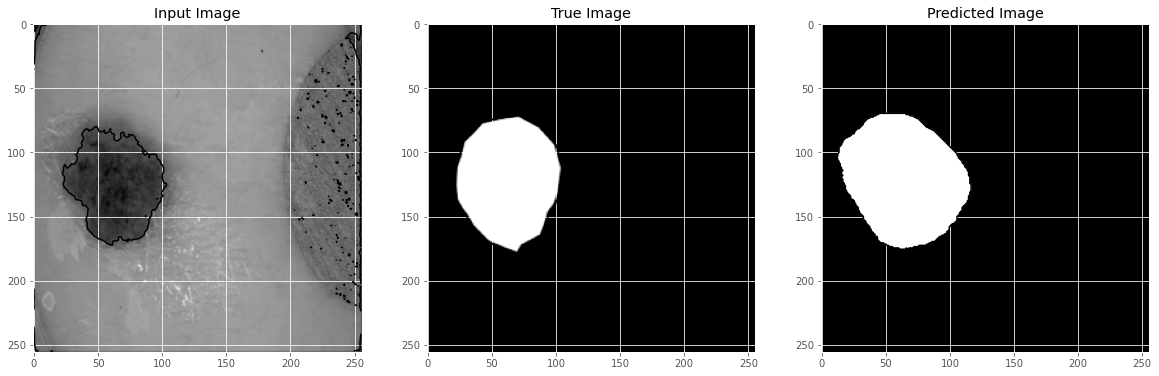

In [96]:
plot_Oasis(X_test,y_test,test_preds_reshape)

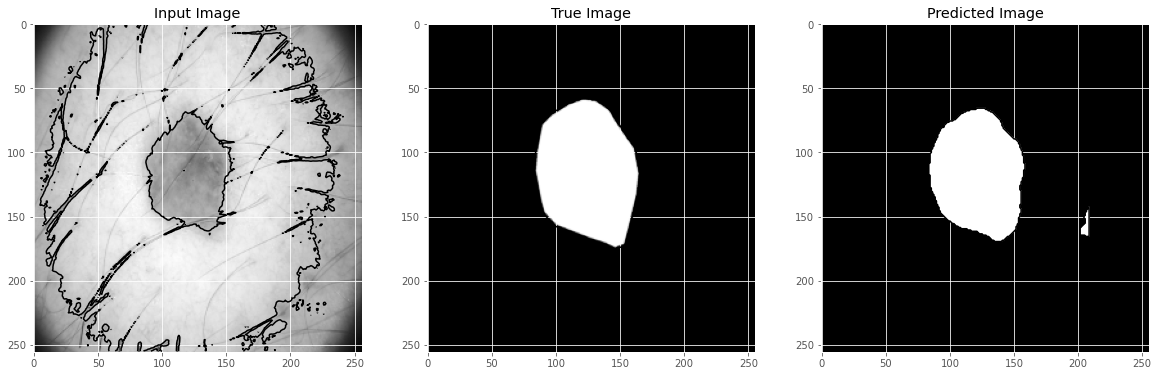

In [90]:
plot_Oasis(X_test,y_test,test_preds_reshape)

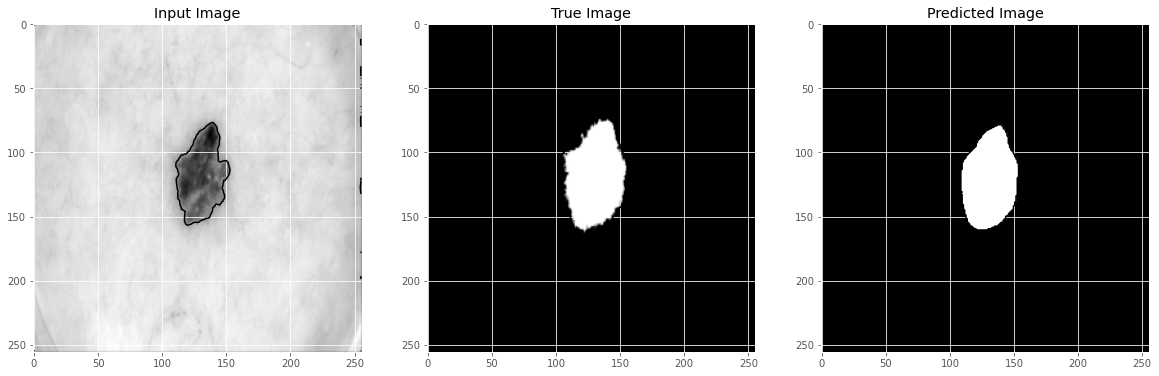

In [88]:
plot_Oasis(X_test,y_test,test_preds_reshape)